# Kalman filter implementation

We are given the state space model

\begin{equation}
\begin{array}{rclll}
x_{t+1} & = & A_{o}x_{t}+Cw_{t+1} & \qquad n\times 1 & \qquad w_{t+1}\sim
N\left( 0,I_{p}\right)  \\
y_{t} & = & Gx_{t}+v_{t} & \qquad m\times 1 & \qquad v_{t}\sim N\left(
0,R\right) .%
\end{array}
\label{eq:KF_system}
\end{equation}

Here, $x_{t}$ is an unobservable state vector that follows a Gaussian Markov
process, $y_{t}$, is a measurement vector and $v_{t}$ is measurement noise
independent of $\left\{ w_{t}\right\} _{t=1}^{\infty }$. We assume an
initial condition

\begin{equation}
x_{0}\sim N\left( \hat{x}_{0},\Sigma _{0}\right) \text{.}
\label{eq:KF_prior}
\end{equation}

The Kalman (1960) filtering algorithm leads to a recursive formula for
the best predictor of $x_{t}$ given observations $y^{t-1}=\left(
y_{t-1},\ldots ,y_{0}\right) $. Because of the linear-Gaussian structure of
the whole system, we can infer that the predictor will also be Gaussian, so
it is sufficient to construct predictors for the first two moments of its
distribution

\begin{eqnarray}
\hat{x}_{t} &=&E\left[ x_{t}\mid y^{t-1}\right]   \label{eq:KF_xhat} \\
\Sigma _{t} &=&E\left[ \left( x_{t}-\hat{x}_{t}\right) \left( x_{t}-\hat{x}%
_{t}\right) ^{\prime }\right] .  \notag
\end{eqnarray}

The solution in the form of an innovations representation is given by the system of equations

\begin{eqnarray}
a_{t} &=&y_{t}-G\hat{x}_{t}  \label{eq:KF_filtering} \\
K_{t} &=&A_{o}\Sigma _{t}G^{\prime }\left( G\Sigma _{t}G^{\prime }+R\right)
^{-1}  \notag \\
\hat{x}_{t+1} &=&A_{o}\hat{x}_{t}+K_{t}a_{t}  \notag \\
\Sigma _{t+1} &=&\left( A_{o}-K_{t}G\right) \Sigma _{t}\left(
A_{o}-K_{t}G\right) ^{\prime }+CC^{\prime }+K_{t}RK_{t}^{\prime }  \notag
\end{eqnarray}

and, for a sequence of data $y_t$, $t = 0,1,\ldots,T-1$, yields the path $\hat{x}_t$, $\Sigma_t$, $t=1,\ldots,T$.

## Implementation

We first write a function that takes as input the model parameters, the prior parameters, and data $y_t$, $t=0,1,\ldots,T-1$ and produces the filtered path $\hat{x}_t$ and variance $\Sigma_t$, $t=1,\ldots,T$.

In [1]:
# import some useful predefined functions from the course package
from course import *

Done everything.


In [2]:
def Kalman_filter(model,y):
    # model: model parameters in matrix form
    # data: m x T matrix of data, one vector of observations in each column
    Ao,C,G,R = model["Ao"],model["C"],model["G"],model["R"]
    m,T,n,p = y.shape[0], y.shape[1], C.shape[0], C.shape[1]
    
    xhat, Sigmahat = np.empty([n,T+1]), np.empty([n,n,T+1])
    xhat[:,0] = model["x0hat"]
    Sigmahat[:,:,0] = model["Sigma0hat"]
    
    for t in range(T):
        a = y[:,t] - G*xhat[:,t]
        K = Ao*Sigmahat[:,:,t]*G.transpose()*np.linalg.inv(G*Sigmahat[:,:,t]*G.transpose() + R)
        xhat[:,t+1] = Ao*xhat[:,t] + K*a
        Sigmahat[:,:,t+1] = (Ao-K*G)*Sigmahat[:,:,t]*(Ao-K*G).transpose()  + C*C.transpose() + K*R*K.transpose()
    
    return xhat, Sigmahat

Load GDP data from FRED.

In [3]:
# myLoadDataFRED uses the pandas_reader.data.Reader function to download time series from FRED
data_Y = myLoadDataFRED(series=['GDPC1'],transform='none')
data = 4*np.asmatrix(np.log(data_Y['GDPC1'][1:]) - np.log(data_Y['GDPC1'][:-1]))
data = data - data.mean()
data_year = data_Y["year"][1:]

Run alternative models.

In [4]:
# baseline model parameters
model = {}
model["Ao"],model["C"],model["G"],model["R"] = np.asmatrix(0.98),np.asmatrix(0.02),np.asmatrix(1),np.asmatrix(0.05**2)
model["x0hat"],model["Sigma0hat"] = 0, 0.1**2

model_benchmark = model.copy()

xhat_benchmark,Sigmahat_benchmark = Kalman_filter(model,data)

# lower persistence of the state
# adjusting volatility of shocks of the hidden state so that unconditional volatility stays the same
Aonew = 0.25
Cnew = model['C'] * np.power(((1-Aonew**2)/(1-model['Ao']**2)),0.5)
model["Ao"],model["C"] = Aonew,Cnew
xhat_less_pers,Sigmahat_less_pers = Kalman_filter(model,data)

# more noise in the signal
model = model_benchmark.copy()
model["R"] = 0.15**2
xhat_more_noise,Sigmahat_more_noise = Kalman_filter(model,data)

Plot data.

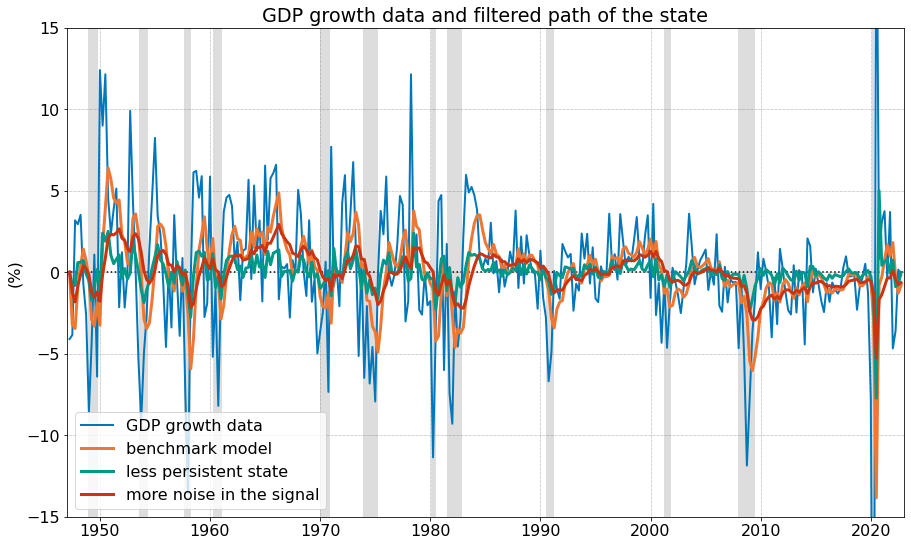

In [5]:
fig_param = {'figsize' : [15,9], 'fontsize': 16, 'subplots': [1,1],
         'title': 'GDP growth data and filtered path of the state',#'Central Bank Policy Rates',
         'xlim': [1947,2023], 'ylim': [-15,15],
         'xlabel': '', 'ylabel': '(%)',
         'ylogscale': False,
         'showgrid': True, 'highlightzero': True,
         'showNBERrecessions' : True, 'showNBERrecessions_y': [-30,30]}
    
fig,ax = myGenerateTSPlot(fig_param)

ax.plot(data_year.transpose(),data[0,:].transpose()*100,
            linewidth=2,color=myColor['tolVibrantBlue'],label='GDP growth data')
ax.plot(data_year,np.matrix.flatten(xhat_benchmark[:,:-1])*100,
            linewidth=3,color=myColor['tolVibrantOrange'],label='benchmark model')
ax.plot(data_year,np.matrix.flatten(xhat_less_pers[:,:-1])*100,
            linewidth=3,color=myColor['tolVibrantTeal'],label='less persistent state')
ax.plot(data_year,np.matrix.flatten(xhat_more_noise[:,:-1])*100,
            linewidth=3,color=myColor['tolVibrantRed'],label='more noise in the signal')

x = ax.legend(loc="lower left")

fig.set_facecolor('#FFFFFF')
fig.savefig('graphs/filtering_gdp_path.pdf',bbox_inches='tight')

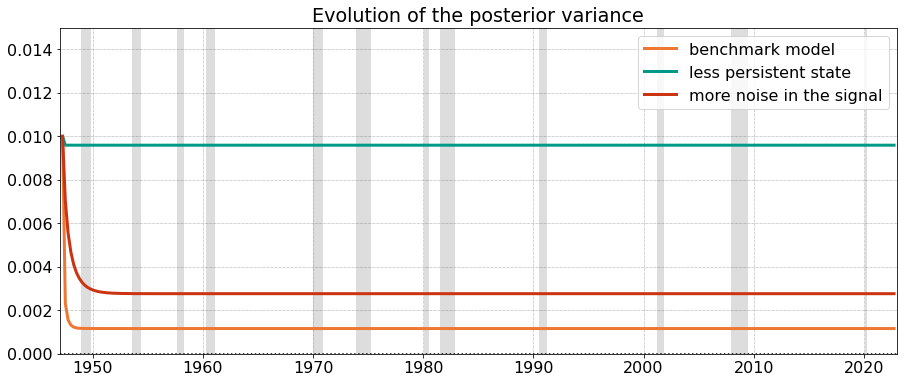

In [6]:
fig_param = {'figsize' : [15,6], 'fontsize': 16, 'subplots': [1,1],
         'title': 'Evolution of the posterior variance',
         'xlim': [1947,2023], 'ylim': [0,0.015],
         'xlabel': '', 'ylabel': '',
         'ylogscale': False,
         'showgrid': True, 'highlightzero': True,
         'showNBERrecessions' : True, 'showNBERrecessions_y': [-30,30]}
    
fig,ax = myGenerateTSPlot(fig_param)

ax.plot(data_year,np.matrix.flatten(Sigmahat_benchmark[:,:,:-1]),
            linewidth=3,color=myColor['tolVibrantOrange'],label='benchmark model')
ax.plot(data_year,np.matrix.flatten(Sigmahat_less_pers[:,:,:-1]),
            linewidth=3,color=myColor['tolVibrantTeal'],label='less persistent state')
ax.plot(data_year,np.matrix.flatten(Sigmahat_more_noise[:,:,:-1]),
            linewidth=3,color=myColor['tolVibrantRed'],label='more noise in the signal')

x = ax.legend(loc="upper right")

fig.set_facecolor('#FFFFFF')
fig.savefig('graphs/filtering_gdp_variance.pdf',bbox_inches='tight')